In [729]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import imageio
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [730]:
class ZeldaLevelDataset(Dataset):
    """Zelda Game levels dataset."""

    def __init__(self, data_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_dir = data_dir
        self.levels = self.load_levels()

    def __len__(self):
        return len(self.levels)

    def __getitem__(self, idx):
        return self.levels[idx]
    
    def load_levels(self):
        levels = []
        directory = os.fsencode(self.data_dir)
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".pt"): 
                level = torch.load(self.data_dir + '/' + filename).float()
                levels.append(level)
        return levels
                
        

In [731]:
#transform = transforms.Compose([
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,),(0.5,)),
#])
to_pil_image = transforms.ToPILImage()
train_data = ZeldaLevelDataset('./data/tensorizedConv/')
print("data size", len(train_data))

data size 1358


In [732]:
# learning parameters
no_cuda = False
batch_size = 16
epochs = 10000
sample_size = 64 # fixed sample size
nz = 8 # latent vector size
seed = 2020
temperature = 1.0
hard = False
categorical_dim = 10
k = 1 # number of steps to apply to the discriminator
is_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
torch.manual_seed(seed)
if is_cuda:
    torch.cuda.manual_seed(seed)

In [733]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [734]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


In [735]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
        U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    permuted_logits = logits.permute(0,2,3,1)
    permuted_y = gumbel_softmax_sample(permuted_logits, temperature)
    #if not hard:
    #    return y.view(-1, nz * categorical_dim)
    
    shape = permuted_y.size()
    _, ind = permuted_y.max(dim=-1)
    y_hard = torch.zeros_like(permuted_y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - permuted_y).detach() + permuted_y
    y_final = y_hard.permute(0,3,1,2)
    return y_final#.view(-1, latent_dim * categorical_dim)

In [736]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [737]:
# testing
print(iter(train_loader).next().shape)

torch.Size([16, 10, 16, 11])


In [738]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1760),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 16, 110)
    
class GeneratorConv(nn.Module):
    def __init__(self, nz, temp):
        super(GeneratorConv, self).__init__()
        self.nz = nz
        n_nodes = 64
        self.main = nn.Sequential(
            nn.Linear(nz, n_nodes),
            nn.LeakyReLU(0.05),
            Reshape(-1, 64, 1, 1),
            nn.ConvTranspose2d(64, 48, 3, 2, bias=False),
            #nn.BatchNorm2d(64),
            #nn.ReLU(True),
            
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(48, 32, 3, 2, bias=False),
            
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(32, 16, 3, 1, bias=False),
            
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(16, 10, (8,3), 1, bias=False),
            #nn.BatchNorm2d(32),
            #nn.ReLU(True),
            #nn.LeakyReLU(0.2),
            
            #nn.ConvTranspose2d(32, 16, (2,2), 2, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(True),
            #nn.LeakyReLU(0.2),
            
            #nn.ConvTranspose2d(16, 10, (2,1), 2, bias=False),
            #nn.Tanh()
        )

    def forward(self, x, temp, hard):
        x = self.main(x)
        y = gumbel_softmax(x, temp, hard)
        z = F.softmax(x, dim=1)
        return y, z

In [739]:
generator = GeneratorConv(nz, temperature).to(device)
#generator.apply(weights_init)
print(generator)

GeneratorConv(
  (main): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Reshape()
    (3): ConvTranspose2d(64, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): ConvTranspose2d(48, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (6): LeakyReLU(negative_slope=0.2)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(16, 10, kernel_size=(8, 3), stride=(1, 1), bias=False)
  )
)


In [740]:
# CONV shape tests
test_level = torch.rand(1, 10, 16, 11)

#conv1 = nn.Conv2d(10, 16, 4, 1, bias=False)
#conv2 = nn.Conv2d(16, 32, 4, 1, bias=False)
#conv3 = nn.Conv2d(32, 48, 4, 1, bias=False)
#conv4 = nn.Conv2d(48, 64, (3,1), 1, bias=False)
#flatt = nn.Flatten()
#lin1 = nn.Linear(64*5*2, 128)

conv1 = nn.Conv2d(10, 16, (8,3), 2, bias=False)
conv2 = nn.Conv2d(16, 24, 3, 2, bias=False)
flatt = nn.Flatten()
lin1 = nn.Linear(96, 1)


print("dis")
x = conv1(test_level)
print(x.shape)
x = conv2(x)
print(x.shape)
#x = conv3(x)
#print(x.shape)
#x = conv4(x)
#print(x.shape)
x = flatt(x)
print(x.shape)
x = lin1(x)
print(x.shape)

print("gen")
test_latent = torch.rand(1, 8)
#deconv1 = nn.ConvTranspose2d(128, 64, (3,2), 1, bias=False)
#deconv2 = nn.ConvTranspose2d(64, 32, (2,2), 1, bias=False)
#deconv3 = nn.ConvTranspose2d(32, 16, (2,2), 2, bias=False)
#deconv4 = nn.ConvTranspose2d(16, 10, (2,1),2, bias=False)
#y = deconv1(test_latent)
lin1 = nn.Linear(8, 64)
reshape = Reshape(-1, 64, 1, 1)
deconv1 = nn.ConvTranspose2d(64, 48, 3, 2, bias=False)
deconv2 = nn.ConvTranspose2d(48, 32, 3, 2, bias=False)
deconv3 = nn.ConvTranspose2d(32, 16, 3, 1, bias=False)
deconv4 = nn.ConvTranspose2d(16, 10, (8,3), 1, bias=False)

y = lin1(test_latent)
print(y.shape)
y = reshape(y)
print(y.shape)
y = deconv1(y)
print(y.shape)
y = deconv2(y)
print(y.shape)
y = deconv3(y)
print(y.shape)
y = deconv4(y)
print(y.shape)
print(generator(test_latent, temperature, hard))


dis
torch.Size([1, 16, 5, 5])
torch.Size([1, 24, 2, 2])
torch.Size([1, 96])
torch.Size([1, 1])
gen
torch.Size([1, 64])
torch.Size([1, 64, 1, 1])
torch.Size([1, 48, 3, 3])
torch.Size([1, 32, 7, 7])
torch.Size([1, 16, 9, 9])
torch.Size([1, 10, 16, 11])
(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 1.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 1.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ...

In [741]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 1760
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 1760)
        return self.main(x)

class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.main = nn.Sequential(
            # input is B x C x H x W
            # B = 16, C = 10, H = 16, W = 11
            nn.Conv2d(10, 16, (8,3), 2, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (16+0-4)/2 + 1 = 7, W = (in+2P-k)/S + 1 = (11+0-3)/2 + 1 = 5
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(16, 24, 3, 2, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (7+0-3)/2 + 1 = 3, W = (in+2P-k)/S + 1 = (5+0-3)/2 + 1 = 2
            nn.BatchNorm2d(24),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            #nn.Conv2d(32, 64, 4, 1, bias=False),
            # output:
            # B = 16, C = 1, H = (in+2P-k)/S + 1 = (10+0-4)/2 + 1 = 7, W = (in+2P-k)/S + 1 = (5+0-4)/2 + 1 = 2
            #nn.BatchNorm2d(64),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Conv2d(64, 128, (3,1), 1, bias=False),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(96, 1),
            #nn.ReLU(),
            #nn.Linear(256, 64),
            #nn.ReLU(),
            #nn.Linear(64, 16),
            #nn.ReLU(),
            #nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [742]:
discriminator = DiscriminatorConv().to(device)
#discriminator.apply(weights_init)
print(discriminator)

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 16, kernel_size=(8, 3), stride=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(16, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=96, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [743]:

temp_min = 0.5
ANNEAL_RATE = 0.00003
if is_cuda:
    generator.cuda()
    discriminator.cuda()

In [744]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [745]:
gan_criterion = nn.BCELoss()

In [746]:
from semantic_loss_pytorch import SemanticLoss
sl = SemanticLoss("constraints/basic_constraint.sdd", "constraints/basic_constraint.vtree")
sl_constraints = []
for i in range(10):
    if i == 6:
        continue
    sl_constraints.append(SemanticLoss(f"constraints/final/constraint_{i}.sdd", f"constraints/final/constraint_{i}.vtree"))

batch_size = 64
# constraints over a 2x2 variable
xlevel = torch.rand((batch_size, 10, 16, 11))
#print(sl(probabilities=xlevel))
xlevel = F.softmax(xlevel, dim=1)
#print(sl(probabilities=xlevel))
for i in range(len(sl_constraints)):
    x = xlevel[:, i, :, :]
    #print(x[0])
    loss = sl_constraints[i](probabilities=x)
    print(loss)


tensor(9.7390)
tensor(9.6694)
tensor(9.6578)
tensor(9.7118)
tensor(9.7071)
tensor(9.6864)
tensor(9.7367)
tensor(8.8034)
tensor(9.6424)


In [747]:
#criterion = nn.BCEWithLogitsLoss()
#criterion = can_loss

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator
sats = []

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

real_label = 1.
fake_label = 0.

# create the noise vector
noise = create_noise(64, nz)

In [748]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [749]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [750]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, temp, hard):
    optimizer.zero_grad()
    b_size = data_real.size(0)
    
    real_preds = discriminator(data_real)
    real_label = label_real(b_size)
    real_loss = gan_criterion(real_preds, real_label)
    real_score = torch.mean(real_preds).item()
    
    latent = create_noise(b_size, nz)
    fake_levels, _ = generator(latent, temp, hard)
    
    fake_preds = discriminator(fake_levels)
    fake_label = label_fake(b_size)
    fake_loss = gan_criterion(fake_preds, fake_label)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward()
    optimizer.step()
    
    return loss.item(), real_score, fake_score

In [751]:
def wall_var(fake_levels):
    b_size = fake_levels.shape[0]
    
    top_outer_wall = torch.prod(fake_levels[:, 8, 0, :].view(b_size, -1), dim=1)
    bottom_outer_wall = torch.prod(fake_levels[:, 8, 15, :].view(b_size, -1), dim=1)
    left_outer_wall = torch.prod(fake_levels[:, 8, 1:15, 0].view(b_size, -1), dim=1)
    right_outer_wall = torch.prod(fake_levels[:, 8, 1:15, 10].view(b_size, -1), dim=1)
    
    outer_walls = top_outer_wall * bottom_outer_wall * left_outer_wall * right_outer_wall
    return outer_walls.unsqueeze(1)
    
def semantic_loss(fake_levels):
    outer_walls = wall_var(fake_levels) + 1e-8
    #print(torch.sum(outer_walls))
    loss = sl(probabilities=outer_walls)
    return loss

rndtest = torch.rand(64, 10, 16, 11)
print(torch.sum(rndtest))
print(semantic_loss(torch.rand(64, 10, 16, 11)))

tensor(56448.2969)
tensor(18.4207)


In [752]:
# function to train the generator network
def train_generator(optimizer, temp, hard, b_size):
    optimizer.zero_grad()
    
    latent = create_noise(b_size, nz)
    fake_levels_discrete, fake_levels_probs = generator(latent, temp, hard)
    
    preds = discriminator(fake_levels_discrete)
    label = label_real(b_size)
    adversarial_loss = gan_criterion(preds, label)
    #constraint_loss = can_loss(fake_levels)
    
    #loss = adversarial_loss + constraint_loss
    #selected = fake_levels[:, 8, 0, :].unsqueeze(2)
    #opposite = 1 - selected
    #third_tensor = torch.cat((selected, opposite), 2)
    
    #loss = torch.tensor(0.0)
    #with io.capture_output() as captured:
    #    for i in range(third_tensor.shape[0]):
    #        third_tensor_one = third_tensor[i]
#
    #        loss += circuit_cons(third_tensor_one)
    #loss /= b_size
    constraint_loss = 0.0
    
    #for i in range(len(sl_constraints)):
    #    x = fake_levels_probs[:, i, :, :]
    #    constraint_loss += sl_constraints[i](probabilities=x)
        
    #x = fake_levels_probs[:, 8, :, :]
    #constraint_loss = sl(probabilities=fake_levels_probs)
    #print(torch.sum(fake_levels_probs))
    constraint_loss = semantic_loss(fake_levels_probs)
    #print(constraint_loss)
    
    loss = adversarial_loss + constraint_loss
    
    loss.backward()
    optimizer.step()
    
    #loss_constraint = can_loss(data_fake)
    #loss_constraint.backward()
    
    return loss.item(), constraint_loss.item()

In [753]:
def transform_to_image_format(level):
    colorR = torch.tensor([0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0])
    colorG = torch.tensor([0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0])
    colorB = torch.tensor([0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0])
    
    colorMap = torch.tensor([[0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0],
                            [0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0],
                            [0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0]]).transpose(0,1)
    permuted_level = level.permute(0,2,3,1)
    
    colored_permuted_level = torch.matmul(permuted_level,colorMap)
    colored_level = colored_permuted_level.permute(0,3,1,2)
    
    return colored_level

In [754]:
generator.train()
discriminator.train()

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 16, kernel_size=(8, 3), stride=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(16, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=96, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    sat = 0.0
    temp = temperature
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        level = data
        level = level.to(device)
        b_size = len(level)
        
        # train the discriminator network
        loss_d_cur, real_score, fake_score = train_discriminator(optim_d, level, temp, hard)
        loss_d += loss_d_cur
        
        # train the generator network
        for _ in range(1):
            loss_g_cur, sat_cur = train_generator(optim_g, temp, hard, b_size)
        loss_g += loss_g_cur
        sat += sat_cur
        
        if bi % 100 == 1:
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * bi), temp_min)
        
    # create the final fake image for the epoch
    generated_level, _ = generator(noise, temp, hard)
    generated_level = generated_level.cpu().detach()
    # make the images as grid
    #generated_level = transform_to_image_format(generated_level)
    #generated_level = make_grid(generated_level)
    # save the generated torch tensor models to disk
    #save_generator_image(generated_level, f"./outputs/gen_img{epoch}.png")
    images.append(generated_level)
    epoch_loss_g = loss_g / (bi+1) # total generator loss for the epoch
    epoch_loss_d = loss_d / (bi+1) # total discriminator loss for the epoch
    epoch_sat = sat / (bi+1)
    if epoch % 99 == 0:
        torch.save(generator.state_dict(), f'./outputs/generators/final_v1/generator{epoch/99}.pth')
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    #epoch_sat = satisfaction(generated_level)
    sats.append(epoch_sat)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g}, Discriminator loss: {epoch_loss_d}, Satisfaction: {epoch_sat}")
    

85it [00:03, 21.97it/s]                                                                                                                                                                                                                       


Epoch 0 of 10000
Generator loss: 19.075162618300492, Discriminator loss: 1.0881056904792785, Satisfaction: 18.42068099975586


85it [00:03, 26.84it/s]                                                                                                                                                                                                                       


Epoch 1 of 10000
Generator loss: 19.194301717421588, Discriminator loss: 0.9088693331269657, Satisfaction: 18.42068099975586


85it [00:02, 29.78it/s]                                                                                                                                                                                                                       


Epoch 2 of 10000
Generator loss: 19.566594987757064, Discriminator loss: 0.6403715067050036, Satisfaction: 18.42068099975586


85it [00:03, 27.77it/s]                                                                                                                                                                                                                       


Epoch 3 of 10000
Generator loss: 19.896893534940833, Discriminator loss: 0.45952771516407237, Satisfaction: 18.42068099975586


85it [00:04, 18.18it/s]                                                                                                                                                                                                                       


Epoch 4 of 10000
Generator loss: 20.12511230917538, Discriminator loss: 0.3281862544662812, Satisfaction: 18.42068099975586


85it [00:07, 11.55it/s]                                                                                                                                                                                                                       


Epoch 5 of 10000
Generator loss: 20.208732470344096, Discriminator loss: 0.28268041172448327, Satisfaction: 18.42068099975586


85it [00:07, 11.41it/s]                                                                                                                                                                                                                       


Epoch 6 of 10000
Generator loss: 20.36926846223719, Discriminator loss: 0.23949893590281993, Satisfaction: 18.42068099975586


85it [00:08, 10.02it/s]                                                                                                                                                                                                                       


Epoch 7 of 10000
Generator loss: 20.534134876026826, Discriminator loss: 0.20407806126510394, Satisfaction: 18.42068099975586


85it [00:09,  8.78it/s]                                                                                                                                                                                                                       


Epoch 8 of 10000
Generator loss: 20.77143061020795, Discriminator loss: 0.1607602043186917, Satisfaction: 18.42068099975586


85it [00:12,  6.60it/s]                                                                                                                                                                                                                       


Epoch 9 of 10000
Generator loss: 20.97456476548139, Discriminator loss: 0.13586334708858938, Satisfaction: 18.42068099975586


85it [00:14,  6.05it/s]                                                                                                                                                                                                                       


Epoch 10 of 10000
Generator loss: 21.189156700583066, Discriminator loss: 0.10872777121908525, Satisfaction: 18.42068099975586


85it [00:12,  6.65it/s]                                                                                                                                                                                                                       


Epoch 11 of 10000
Generator loss: 21.360600550034466, Discriminator loss: 0.08954713397166308, Satisfaction: 18.42068099975586


85it [00:16,  5.25it/s]                                                                                                                                                                                                                       


Epoch 12 of 10000
Generator loss: 21.593450456507064, Discriminator loss: 0.07586674624506165, Satisfaction: 18.42068099975586


85it [00:16,  5.08it/s]                                                                                                                                                                                                                       


Epoch 13 of 10000
Generator loss: 21.724570285572725, Discriminator loss: 0.06441323349581045, Satisfaction: 18.42068099975586


85it [00:13,  6.42it/s]                                                                                                                                                                                                                       


Epoch 14 of 10000
Generator loss: 21.922811059390796, Discriminator loss: 0.05690219840582679, Satisfaction: 18.42068099975586


85it [00:12,  6.82it/s]                                                                                                                                                                                                                       


Epoch 15 of 10000
Generator loss: 22.07086908677045, Discriminator loss: 0.0478101970956606, Satisfaction: 18.42068099975586


85it [00:14,  5.88it/s]                                                                                                                                                                                                                       


Epoch 16 of 10000
Generator loss: 22.212563346414004, Discriminator loss: 0.040938207419479594, Satisfaction: 18.42068099975586


85it [00:13,  6.49it/s]                                                                                                                                                                                                                       


Epoch 17 of 10000
Generator loss: 22.33782299266142, Discriminator loss: 0.03581998841289212, Satisfaction: 18.42068099975586


85it [00:12,  6.76it/s]                                                                                                                                                                                                                       


Epoch 18 of 10000
Generator loss: 22.52059741300695, Discriminator loss: 0.03069872558116913, Satisfaction: 18.42068099975586


85it [00:19,  4.29it/s]                                                                                                                                                                                                                       


Epoch 19 of 10000
Generator loss: 22.640865281048942, Discriminator loss: 0.028002746972967597, Satisfaction: 18.42068099975586


85it [00:15,  5.57it/s]                                                                                                                                                                                                                       


Epoch 20 of 10000
Generator loss: 22.749217852424174, Discriminator loss: 0.025331605927032583, Satisfaction: 18.42068099975586


85it [00:13,  6.10it/s]                                                                                                                                                                                                                       


Epoch 21 of 10000
Generator loss: 22.858367044785442, Discriminator loss: 0.022093500733813817, Satisfaction: 18.42068099975586


85it [00:19,  4.46it/s]                                                                                                                                                                                                                       


Epoch 22 of 10000
Generator loss: 22.972010354434744, Discriminator loss: 0.019178817004841916, Satisfaction: 18.42068099975586


85it [00:20,  4.20it/s]                                                                                                                                                                                                                       


Epoch 23 of 10000
Generator loss: 23.087611276963177, Discriminator loss: 0.01702105173950686, Satisfaction: 18.42068099975586


85it [00:25,  3.34it/s]                                                                                                                                                                                                                       


Epoch 24 of 10000
Generator loss: 23.243638543521655, Discriminator loss: 0.015496489537112853, Satisfaction: 18.42068099975586


85it [00:21,  3.96it/s]                                                                                                                                                                                                                       


Epoch 25 of 10000
Generator loss: 23.315800184362075, Discriminator loss: 0.01471279474961407, Satisfaction: 18.42068099975586


85it [00:21,  4.02it/s]                                                                                                                                                                                                                       


Epoch 26 of 10000
Generator loss: 23.453754245533663, Discriminator loss: 0.013898564875125885, Satisfaction: 18.42068099975586


85it [00:35,  2.40it/s]                                                                                                                                                                                                                       


Epoch 27 of 10000
Generator loss: 23.482887066111847, Discriminator loss: 0.012042620323379251, Satisfaction: 18.42068099975586


85it [00:19,  4.34it/s]                                                                                                                                                                                                                       


Epoch 28 of 10000
Generator loss: 23.63126891641056, Discriminator loss: 0.011381559879245128, Satisfaction: 18.42068099975586


85it [00:18,  4.64it/s]                                                                                                                                                                                                                       


Epoch 29 of 10000
Generator loss: 23.715542176190546, Discriminator loss: 0.009975401558639373, Satisfaction: 18.42068099975586


85it [00:23,  3.62it/s]                                                                                                                                                                                                                       


Epoch 30 of 10000
Generator loss: 23.813566970825196, Discriminator loss: 0.009315113487708217, Satisfaction: 18.42068099975586


85it [00:28,  2.98it/s]                                                                                                                                                                                                                       


Epoch 31 of 10000
Generator loss: 23.925601959228516, Discriminator loss: 0.008393060142064796, Satisfaction: 18.42068099975586


85it [00:16,  5.16it/s]                                                                                                                                                                                                                       


Epoch 32 of 10000
Generator loss: 23.995920383228974, Discriminator loss: 0.007721137956661336, Satisfaction: 18.42068099975586


85it [00:16,  5.22it/s]                                                                                                                                                                                                                       


Epoch 33 of 10000
Generator loss: 24.12461491753073, Discriminator loss: 0.007535987380234634, Satisfaction: 18.42068099975586


85it [00:15,  5.50it/s]                                                                                                                                                                                                                       


Epoch 34 of 10000
Generator loss: 24.144817150340362, Discriminator loss: 0.0068934607812586954, Satisfaction: 18.42068099975586


85it [00:15,  5.59it/s]                                                                                                                                                                                                                       


Epoch 35 of 10000
Generator loss: 24.234077004825366, Discriminator loss: 0.006286041663192651, Satisfaction: 18.42068099975586


85it [00:20,  4.19it/s]                                                                                                                                                                                                                       


Epoch 36 of 10000
Generator loss: 24.327655298569624, Discriminator loss: 0.0060204869848402105, Satisfaction: 18.42068099975586


85it [00:29,  2.83it/s]                                                                                                                                                                                                                       


Epoch 37 of 10000
Generator loss: 24.42159960129682, Discriminator loss: 0.005444090049166013, Satisfaction: 18.42068099975586


85it [00:25,  3.37it/s]                                                                                                                                                                                                                       


Epoch 38 of 10000
Generator loss: 24.51935059042538, Discriminator loss: 0.005196811168399804, Satisfaction: 18.42068099975586


85it [00:18,  4.61it/s]                                                                                                                                                                                                                       


Epoch 39 of 10000
Generator loss: 24.55317652085248, Discriminator loss: 0.004988457361126648, Satisfaction: 18.42068099975586


85it [00:22,  3.75it/s]                                                                                                                                                                                                                       


Epoch 40 of 10000
Generator loss: 24.685585538078758, Discriminator loss: 0.00463544117177234, Satisfaction: 18.42068099975586


85it [00:15,  5.60it/s]                                                                                                                                                                                                                       


Epoch 41 of 10000
Generator loss: 24.677173188153436, Discriminator loss: 0.00410166788736687, Satisfaction: 18.42068099975586


85it [00:25,  3.32it/s]                                                                                                                                                                                                                       


Epoch 42 of 10000
Generator loss: 24.845416461720188, Discriminator loss: 0.0038959451540208916, Satisfaction: 18.42068099975586


85it [00:15,  5.64it/s]                                                                                                                                                                                                                       


Epoch 43 of 10000
Generator loss: 24.879149493049173, Discriminator loss: 0.003766858920126277, Satisfaction: 18.42068099975586


85it [00:13,  6.52it/s]                                                                                                                                                                                                                       


Epoch 44 of 10000
Generator loss: 24.956268086152917, Discriminator loss: 0.003490502677638741, Satisfaction: 18.42068099975586


85it [00:13,  6.35it/s]                                                                                                                                                                                                                       


Epoch 45 of 10000
Generator loss: 25.03534606484806, Discriminator loss: 0.003424281476284651, Satisfaction: 18.42068099975586


85it [00:21,  3.88it/s]                                                                                                                                                                                                                       


Epoch 46 of 10000
Generator loss: 25.13997143016142, Discriminator loss: 0.003134179420714431, Satisfaction: 18.42068099975586


85it [00:21,  4.03it/s]                                                                                                                                                                                                                       


Epoch 47 of 10000
Generator loss: 25.17452621459961, Discriminator loss: 0.002929946977426024, Satisfaction: 18.42068099975586


85it [00:12,  6.55it/s]                                                                                                                                                                                                                       


Epoch 48 of 10000
Generator loss: 25.262860623527974, Discriminator loss: 0.002573948211091406, Satisfaction: 18.42068099975586


85it [00:12,  6.64it/s]                                                                                                                                                                                                                       


Epoch 49 of 10000
Generator loss: 25.279620092055378, Discriminator loss: 0.002543004767914467, Satisfaction: 18.42068099975586


85it [00:12,  6.64it/s]                                                                                                                                                                                                                       


Epoch 50 of 10000
Generator loss: 25.395469104542453, Discriminator loss: 0.0024806851192432293, Satisfaction: 18.42068099975586


85it [00:12,  6.76it/s]                                                                                                                                                                                                                       


Epoch 51 of 10000
Generator loss: 25.506996311860927, Discriminator loss: 0.0022517858620952156, Satisfaction: 18.42068099975586


85it [00:13,  6.29it/s]                                                                                                                                                                                                                       


Epoch 52 of 10000
Generator loss: 25.571685185151942, Discriminator loss: 0.0020452435909058242, Satisfaction: 18.42068099975586


85it [00:13,  6.25it/s]                                                                                                                                                                                                                       


Epoch 53 of 10000
Generator loss: 25.550726183723, Discriminator loss: 0.0019800420699860244, Satisfaction: 18.42068099975586


85it [00:12,  6.67it/s]                                                                                                                                                                                                                       


Epoch 54 of 10000
Generator loss: 25.69463384291705, Discriminator loss: 0.0019402306157109493, Satisfaction: 18.42068099975586


85it [00:12,  6.67it/s]                                                                                                                                                                                                                       


Epoch 55 of 10000
Generator loss: 25.702738952636718, Discriminator loss: 0.001738944386734682, Satisfaction: 18.42068099975586


85it [00:12,  6.65it/s]                                                                                                                                                                                                                       


Epoch 56 of 10000
Generator loss: 25.769187725291534, Discriminator loss: 0.0017469727057580124, Satisfaction: 18.42068099975586


85it [00:13,  6.42it/s]                                                                                                                                                                                                                       


Epoch 57 of 10000
Generator loss: 25.88863484999713, Discriminator loss: 0.001588389797903159, Satisfaction: 18.42068099975586


85it [00:14,  6.06it/s]                                                                                                                                                                                                                       


Epoch 58 of 10000
Generator loss: 25.93502331901999, Discriminator loss: 0.0014613967573763255, Satisfaction: 18.42068099975586


85it [00:12,  6.58it/s]                                                                                                                                                                                                                       


Epoch 59 of 10000
Generator loss: 25.994557279698988, Discriminator loss: 0.0014468006221303607, Satisfaction: 18.42068099975586


85it [00:13,  6.46it/s]                                                                                                                                                                                                                       


Epoch 60 of 10000
Generator loss: 26.02596316618078, Discriminator loss: 0.0014313181382877862, Satisfaction: 18.42068099975586


85it [00:14,  5.85it/s]                                                                                                                                                                                                                       


Epoch 61 of 10000
Generator loss: 26.15509069106158, Discriminator loss: 0.0012998914914479588, Satisfaction: 18.42068099975586


85it [00:19,  4.37it/s]                                                                                                                                                                                                                       


Epoch 62 of 10000
Generator loss: 26.185839439840876, Discriminator loss: 0.0012185832485556603, Satisfaction: 18.42068099975586


85it [00:14,  5.87it/s]                                                                                                                                                                                                                       


Epoch 63 of 10000
Generator loss: 26.183773040771484, Discriminator loss: 0.0011356093146947816, Satisfaction: 18.42068099975586


85it [00:13,  6.27it/s]                                                                                                                                                                                                                       


Epoch 64 of 10000
Generator loss: 26.31311818291159, Discriminator loss: 0.0010707985657705543, Satisfaction: 18.42068099975586


85it [00:17,  4.76it/s]                                                                                                                                                                                                                       


Epoch 65 of 10000
Generator loss: 26.35861583036535, Discriminator loss: 0.0010234932072789354, Satisfaction: 18.42068099975586


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 44/84 [00:07<00:06,  6.45it/s]

In [ ]:
#img_list = []
#G_losses = []
#D_losses = []
#iters = 0

#num_epochs = 10

#print("Starting Training Loop...")
## For each epoch
#for epoch in range(num_epochs):
    # For each batch in the dataloader
#    for i, data in enumerate(train_loader, 0):
#
#        ############################
#        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#        ###########################
#        ## Train with all-real batch
#        discriminator.zero_grad()
        # Format batch
#        real_cpu = data.to(device)
#        b_size = real_cpu.size(0)
#        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
#        output = discriminator(real_cpu)
#        print("output", output.shape, output)
#        print("output0", output[0].shape, output[0])
        # Calculate loss on all-real batch
#        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
#        errD_real.backward()
#        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
#        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
#        fake = generator(noise)
#        label.fill_(fake_label)
        # Classify all fake batch with D
#        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
#        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
#        errD_fake.backward()
#        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
#        errD = errD_real + errD_fake
        # Update D
#        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
#        generator.zero_grad()
#        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
#        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
#        errG = criterion(output, label)
        # Calculate gradients for G
#        errG.backward()
 #       D_G_z2 = output.mean().item()
        # Update G
#        optimizerG.step()

        # Output training stats
#        if i % 50 == 0:
#            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
 #                 % (epoch, num_epochs, i, len(dataloader),
  #                   errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
#        G_losses.append(errG.item())
#        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
#        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#            with torch.no_grad():
#                fake = generator(fixed_noise).detach().cpu()
#            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

 #       iters += 1

In [723]:
print('DONE TRAINING')
torch.save(generator.state_dict(), './outputs/generator_final_v4.pth')

DONE TRAINING


In [724]:
# save the generated images as GIF file
print(images[0].shape)
transformed_images = [transform_to_image_format(img) for img in images]
print(transformed_images[0].shape)
grid_images = [make_grid(img) for img in transformed_images]
print(grid_images[0].shape)
imgs = [np.array(to_pil_image(img)) for img in grid_images]
imageio.mimsave('./outputs/generator_images_final_v4.gif', imgs)

torch.Size([64, 10, 16, 11])
torch.Size([64, 3, 16, 11])
torch.Size([3, 146, 106])


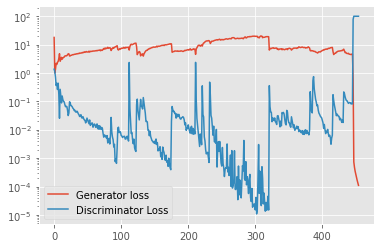

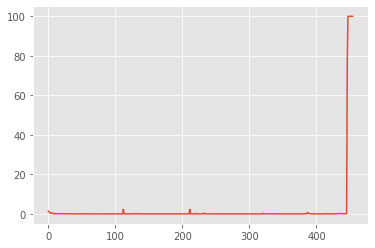

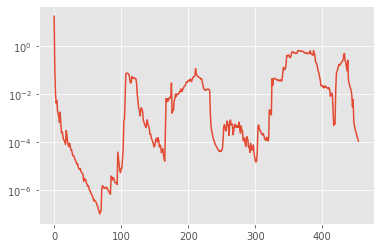

In [725]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.yscale('log')
plt.savefig('./outputs/loss_final_v4.png')
plt.figure()
plt.plot(losses_d, label='Discriminator Loss')
plt.savefig('./outputs/loss_d_final_v4.png')
plt.figure()
plt.plot(sats, label='Constraint satisfaction')
plt.yscale('log')
plt.savefig('./outputs/sat_final_v4.png')